In [3]:

import plotly.express as px
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
from tqdm import tqdm

In [5]:
df = pd.read_json('gdrive/My Drive/NFT DS/CPunk/cpunk_2017_2021.jsonl', lines=True)
len(df)

167492

In [6]:
df.head(5)

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
0,Bid Withdrawn,0xe73a1d,,2021-09-04,2021-09-04,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,263.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


In [7]:
df['date'] = pd.to_datetime(df.date)


In [8]:
df.columns


Index(['txn_type', 'from', 'to', 'date', 'timestamp', 'source', 'eth',
       'punk_id', 'from_wallet_address', 'to_wallet_address', 'type',
       'accessories'],
      dtype='object')

Column Reductions - txn_type, date, eth, punk_id, type, and accessories

In [9]:
df = df[["txn_type", "date", "eth", "punk_id", "type", "accessories"]]
df.head()

,txn_type,date,eth,punk_id,type,accessories
0,Bid Withdrawn,2021-09-04,321.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,2021-09-01,321.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,2021-09-01,320.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,2021-09-01,320.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,2021-09-01,263.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


In [10]:
df = df.explode("type")
df.head()

,txn_type,date,eth,punk_id,type,accessories
0,Bid Withdrawn,2021-09-04,321.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,2021-09-01,321.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,2021-09-01,320.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,2021-09-01,320.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,2021-09-01,263.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]"


In [11]:

fig1 = px.bar(df.drop_duplicates("punk_id")['type'].value_counts().rename_axis('type').reset_index(name='counts'),
             x="type", y="counts", color="type", title="Cryptopunk Type Count")

fig1.show()

In [24]:
df.eth.describe()

count    1.275420e+05
mean     7.071151e+08
std      2.520092e+11
min      0.000000e+00
25%      2.250000e+00
50%      2.199000e+01
75%      5.300000e+01
max      9.000000e+13
Name: eth, dtype: float64

exclude bids and offers that are lower than 50% of median sale value for the punk type

In [13]:
# calcualting median price for transcations in different punk types
median_price = {}
i = 0
all_txns = []
punk_t = df.type.unique() # seperates the different types of punks
dates = sorted(df.date.unique())
prev_date = None


for date in tqdm(dates):
    if prev_date:
        df_up_to = df[(df.date <= date) & (df.date > prev_date)]
    else:
        # only for the first date!
        df_up_to = df[(df.date <= date)]

    median_price = df_up_to[df.txn_type == "Sold"].groupby("type").agg({"eth": "median"})['eth'].to_dict()
    for punk_type in punk_t:
        if punk_type not in median_price:
            # no median price - include all transactions
            all_txns.append(df_up_to[df_up_to.type == punk_type])
        else:
            # only include transactions that are within at least 10% of the median price
            all_txns.append(df_up_to[(df_up_to.type == punk_type) & (df.eth >= median_price[punk_type] * .1)])



    prev_date = date
    

df = pd.concat(all_txns)

  0%|          | 0/1471 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

100%|██████████| 1471/1471 [05:29<00:00,  4.46it/s]


In [14]:

df = df.drop_duplicates(["txn_type", "date", "eth", "punk_id", "type"])
len(df)

123849

In [15]:
max_sold = df[df.txn_type == "Sold"].eth.max()

# include all transactions with offers/bids up to 1.5x larger than largest sale
df = df[df.eth <= max_sold * 1.5 ]

In [16]:
fig2 = plt.figure(figsize=(15,8))
fig2 = px.histogram(df, x='eth', title="All Transaction (ETH Prices)")
fig2.show()

<Figure size 1080x576 with 0 Axes>

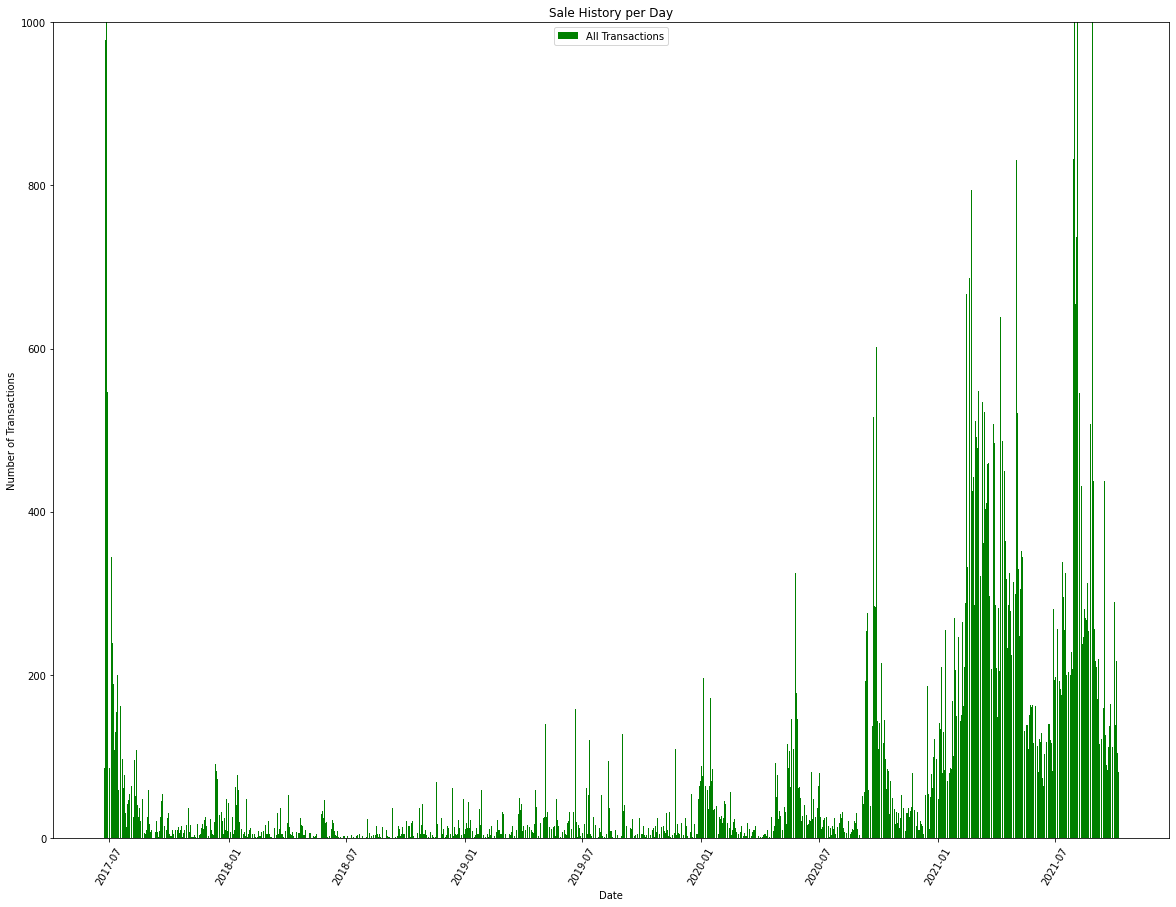

In [17]:
dates = df['date'].value_counts().sort_index().rename_axis('date').reset_index(name='counts')
plt.figure(figsize=(20,15))
plt.bar(dates['date'], dates['counts'], label="All Transactions", color = 'g')
plt.legend()
plt.xticks(rotation=60)
plt.ylim(0, 1000)
plt.title("Sale History per Day")
plt.ylabel("Number of Transactions")
plt.xlabel("Date")
plt.show()

In [19]:
fig3 = px.bar(df[df.txn_type == 'Sold'].groupby("type").agg({"eth": "max"}).
              sort_values(by="eth").reset_index('type'),
             x="type", 
              y="eth", 
              color="type",
              title="Max sale price for each CryptoPunk type")
fig3.show()

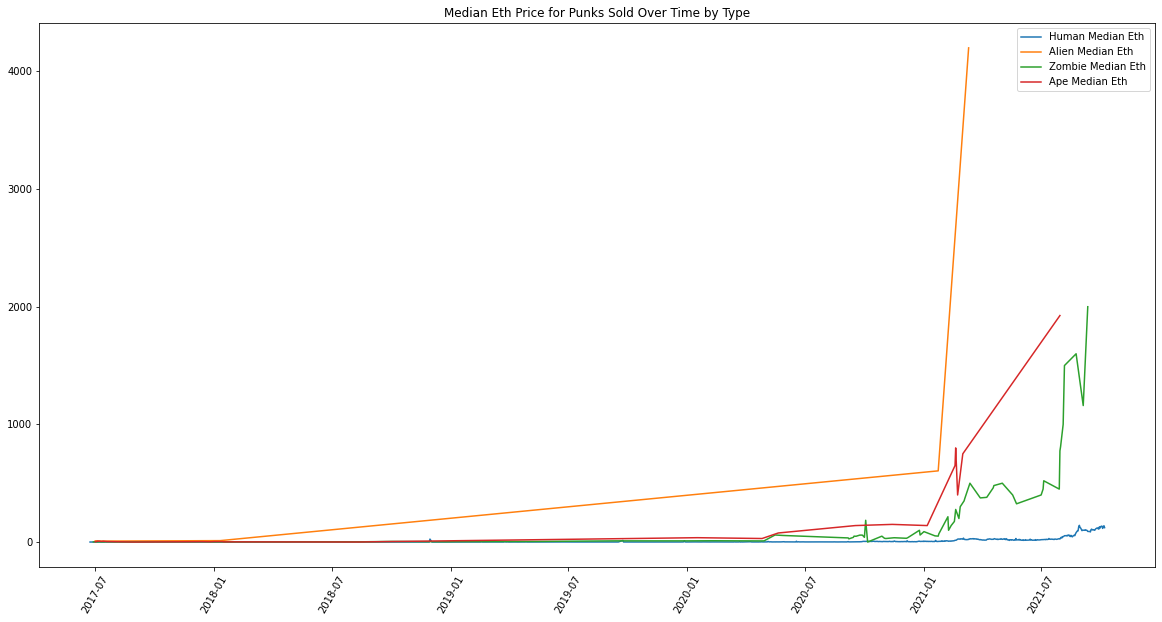

In [20]:
human = df[(df.txn_type == 'Sold') & ((df.type == "Female") | (df.type == "Male")) ].groupby("date").agg({"eth": ["median"]}).reset_index("date")
alien = df[(df.txn_type == 'Sold') & ((df.type == "Alien")) ].groupby("date").agg({"eth": ["median"]}).reset_index("date")
zombie = df[(df.txn_type == 'Sold') & ((df.type == "Zombie")) ].groupby("date").agg({"eth": ["median"]}).reset_index("date")
ape = df[(df.txn_type == 'Sold') & ((df.type == "Ape")) ].groupby("date").agg({"eth": ["median"]}).reset_index("date")
plt.figure(figsize=(20,10))
plt.plot(human['date'], human['eth']['median'], label="Human Median Eth")
plt.plot(alien['date'], alien['eth']['median'], label="Alien Median Eth")
plt.plot(zombie['date'], zombie['eth']['median'], label="Zombie Median Eth")
plt.plot(ape['date'], ape['eth']['median'], label="Ape Median Eth")
plt.legend()
plt.xticks(rotation=60)
plt.title("Median Eth Price for Punks Sold Over Time by Type")
plt.show()

Attributes

In [21]:
df['num_attributes'] = df.accessories.apply(lambda x: len(x))
fig4 = px.bar(df.drop_duplicates("punk_id")['num_attributes'].value_counts().rename_axis('num_attributes').reset_index(name='counts'),
             x="num_attributes", y="counts", color="num_attributes", title="CryptoPunk Attribute Distribution")
fig4.show()

In [22]:
df.drop_duplicates("punk_id")['num_attributes'].value_counts()

3    3830
2    2863
4    1202
1     245
5     156
6      11
0       8
7       1
Name: num_attributes, dtype: int64

In [26]:
#compare number of attributes vs. price
fig5 = px.bar(df[(df.txn_type == "Sold") & ((df.type == "Female") | (df.type == "Male"))].groupby("num_attributes").agg({"eth": "mean"}).reset_index("num_attributes"),
             x="num_attributes", 
             y="eth", 
             color="eth", 
             title="Avg. Price of Human CryptoPunks compared with Attributes")
fig5.show()

In [27]:
#visualize number of attributes vs price for alien
fig = px.bar(df[(df.txn_type == "Sold") & ((df.type == "Alien"))].groupby("num_attributes").agg({"eth": "mean"}).reset_index("num_attributes"),
             x="num_attributes", 
             y="eth", 
             color="eth", 
             title="Avg. Price of Alien CryptoPunks compared with Attributes")
fig.show()

In [62]:
#get number of attributes
df['num_attributes'] = df.accessories.apply(lambda x: len(x))

 CryptoPunk Type Classification (w Hyperparameter Tuning)